**Assignment 2 - Question 3**
- Provide the answers in the provided cell. 

In [ ]:
# Install some dependencies. We will use transformers and datasets package from Huggingface for our experiments. Uncomment the line below to install the dependencies. 
!pip install transformers datasets sentencepiece

In [1]:
# Load the GSM8K dataset. There are two versions: main and Socratic. We are currently interested in main but later on we can explore socratic version. Just pass the name in the command below to load them. 
from datasets import load_dataset
dataset = load_dataset("gsm8k", "main")

Found cached dataset gsm8k (/cluster/home/rdanis/.cache/huggingface/datasets/gsm8k/main/1.1.0/37bfb08b1d4fcbb01f06b03d9e1ef5f1fcbd4d3af3d08842c50d7305091285ba)


  0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
# imports
from dataset import GSMDataset
from transformers import AutoTokenizer, T5ForConditionalGeneration
import torch
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from tqdm import tqdm
from dataset import extract_answer
import re

device = torch.device("cuda")

In [3]:
tokenizer = AutoTokenizer.from_pretrained("t5-small", model_max_length=512)

In [4]:
# We test on 100 samples only for all the experiments
test_samples = dataset["test"][:100]

In [5]:
# Printing a sample from the dataset
# The dataset is a Math Word Problem in the following format. "Ques" represents the main problem and "Solution" contains the step by step solution. The final answer appears after "####"
sample_ques = test_samples["question"][0]
print (f"Ques: {sample_ques}\nSolution: {test_samples['answer'][0]}")

Ques: Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?
Solution: Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eggs a day.
She makes 9 * 2 = $<<9*2=18>>18 every day at the farmer’s market.
#### 18


**Ques 1**: We have training dataset available for GSM8K ("train" parameter in dataset) and we start by training an LLM. We use T5 models for all our experiments (T5 and Flan versions). For training, we use T5-small and train it on GSM8K dataset and report the accuracy on the test set as created above. 
- For training and testing, use the train and test scripts provided in the GitHub (https://github.com/openai/grade-school-math/tree/master/grade_school_math). 
- Make sure to replace the GPT2 tokenizer and model with T5-small from Huggingface (also provided below). 
- For testing run sample.py file for all the 100 samples from the test set (from above). No need to modify the calculator code and keep using one. 
- Finally, report the accuracy of the model on the 100 test samples created above.

NOTE: No need to submit the train and sample code. Only the results are enough. The results are expected in .ccsv format with questions in one column and model output in the second column. Accuracy is calculated based on the final answer only (the one after ####).

**Answer 1**:

In [6]:
#Loading T5 model and analyzing the output out of the box
from transformers import AutoTokenizer, T5ForConditionalGeneration

#Load the tokenizer and the model
tokenizer = AutoTokenizer.from_pretrained("t5-small", model_max_length=512)
model = T5ForConditionalGeneration.from_pretrained("t5-small")

# lets create an input for the model. Here we are testing with one example question out of the box. 
input_sample = sample_ques

# Pass the sample to the model and print the decoded output
input_ids = tokenizer(input_sample, return_tensors="pt").input_ids
outputs = model.generate(input_ids, max_new_tokens=256)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

and bakes muffins for her friends every day with four. Janet’s ducks lay 16 eggs per day. Janet’s ducks lay 16 eggs per day. Janet sells the remainder at the farmers' market daily for $2 per fresh duck egg.


In [7]:
from train import train
# finetune t5
train("t5-small", num_epochs=3, batch_size=32, lr=3e-4)

  0%|          | 0/2 [00:00<?, ?it/s]

/cluster/home/rdanis/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/633 [00:00<?, ?it/s]

Epoch 0 | Train Loss 2.334 | Val Loss 1.656
Epoch 1 | Train Loss 1.500 | Val Loss 1.453
Epoch 2 | Train Loss 1.354 | Val Loss 1.416


In [8]:
from test import test
# use trained model to infer the test samples and save as csv in results
test("t5-small", pre_trained=False)

Model t5-small loaded.


  0%|          | 0/2 [00:00<?, ?it/s]


100%|██████████| 100/100 [01:02<00:00,  1.60it/s]

Accuracy:  0.06


#### **Achieved Accuracy: 6%**

**Ques 2:** Finetuning works well for cases when training data is available. But for cases when there is no training data available, we can first test how the pre-trained models work out of the box in a zero-shot setting. 
- Load versions of T5 models [small, base, and large] from [HuggingFace repo](https://huggingface.co/docs/transformers/model_doc/t5) as demonstrated in the example above and run the inference for entire test set of 100 examples. Calculate the accuracy on the test samples and plot a chart demonstrating how the accuracy scales with model sizes.
NOTE: Template to plot the graph in bar chart format is provided at the end of the document. 

**Answer 2**:

In [9]:
names = ["t5-small", "t5-base", "t5-large"]

In [10]:
# function to compute the accuracies for zero shot setting
def get_accuracies(names, instruction=False):
    
    accuracies = []
    for name in names:
        
        model_answers = []
        questions = test_samples["question"]
        answers = test_samples["answer"]
        
        if instruction:
            # prepend instruction
            questions = ["Answer the following question by reasoning step-by-step. " \
                                  + q for q in test_samples["question"]]
            
        # tokenize
        tokenizer = AutoTokenizer.from_pretrained(name, model_max_length=512)
        input_ids = tokenizer(questions, padding='longest', return_tensors="pt").input_ids
        
        # dataset and dataloader
        test_dset = TensorDataset(input_ids)
        test_loader = DataLoader(test_dset, batch_size=32, shuffle=False)
        
        # model
        model = T5ForConditionalGeneration.from_pretrained(name).to(device)
        model.eval()
        
        # generate answers
        with torch.no_grad():
            for x in tqdm(test_loader):
                x = x[0].to(device)
                outputs = model.generate(input_ids=x, max_new_tokens=256)
                model_answers += [tokenizer.decode(output, skip_special_tokens=True) \
                                  for output in outputs]

        correct = 0

        # compute accuracy
        for (model_answer, answer) in zip(model_answers, answers):
            final_answer = extract_answer(answer)
            # check if last number in predicted answer is the correct one
            if final_answer in model_answer and final_answer == re.findall(r'\d+', model_answer)[-1]:
                correct += 1

        accuracies.append(correct/100)

    return accuracies

In [11]:
accuracies = get_accuracies(names)
accuracies


100%|██████████| 4/4 [00:02<00:00,  1.83it/s]



100%|██████████| 4/4 [00:04<00:00,  1.24s/it]



100%|██████████| 4/4 [00:12<00:00,  3.12s/it]


[0.04, 0.04, 0.04]

In [12]:
# display accuracies
accuracies

[0.04, 0.04, 0.04]

In [13]:
accuracies_t5 = accuracies

In [14]:
# Template to plot graphs. 
import matplotlib.pyplot as plt

def plot(accuracies, fname):
    # Sample data
    sizes = ['60.5M', '223M', '738M']

    # Create a figure and a set of subplots
    fig, ax = plt.subplots()

    # Plot data
    ax.bar(sizes, [100*a for a in accuracies], color=['blue', 'red', 'green'])

    # Set the y axis label
    ax.set_ylabel('Accuracy in %')

    # Set the chart's title
    ax.set_title('Accuracy vs. Model Parameter Count')

    # Set the x axis label
    ax.set_xlabel('Number of parameters')
    plt.savefig(fname)
    plt.show()

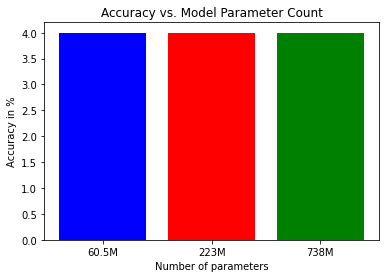

In [15]:
plot(accuracies_t5, "plots/Ques2.png")

**Ques 3**: Without specifying what the model should do for a given problem, the model might feel that the task is a typical sentence completion task which might not be desirable for a question-answering task or machine translation task. *Instruction tuning* is an idea to train these LLMs with instructions for each task which if provided during test time, can assist the model to decide how to approach the task. 
- Now repeat the same experiments with Flan T5 models [small, base, and large] (an instruction tuned version of T5) and plot a chart comparing it with the T5 models in the same last plot:
   - without changing the input style and
   - with adding instruction for each input example (Refer to [FlanT5 paper](https://arxiv.org/pdf/2210.11416.pdf) and figure out the instruction that can prove useful for answering GSM8K dataset).
   
   NOTE that all you need is to load the tokenizer and the model in the above code, and provide the input sample in the desired format. Also, the instructions are task specific meaning a common instruction in the input sample will work for all the examples. No need to write different instructions for each example. 

**Answer 3**:

#### Without changing input style

In [16]:
names = ["google/flan-t5-small", "google/flan-t5-base", "google/flan-t5-large"]

In [17]:
accuracies = get_accuracies(names)


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]

100%|██████████| 4/4 [00:30<00:00,  7.51s/it]


In [18]:
# display accuracies
accuracies

[0.02, 0.03, 0.04]

In [19]:
accuracies_flan = accuracies

#### Changing input style

#### The following string is prepended to each question: 'Answer the following question by reasoning step-by-step.'

In [20]:
names = ["google/flan-t5-small", "google/flan-t5-base", "google/flan-t5-large"]

In [21]:
accuracies = get_accuracies(names, instruction=True)

100%|██████████| 4/4 [00:27<00:00,  6.80s/it]


In [22]:
# display accuracies
accuracies

[0.03, 0.03, 0.09]

In [23]:
accuracies_flan_instruction = accuracies

#### Now we plot all results together.

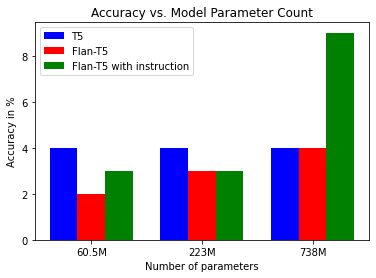

In [24]:
import numpy as np
# make bar plot with grouped bars for each of the three settings

# Sample data
x = np.array([1, 2, 3])
sizes = ['60.5M', '223M', '738M']

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Plot data
ax.bar(x - 0.25, [100*a for a in accuracies_t5], width=0.25, color='blue', label="T5")
ax.bar(x, [100*a for a in accuracies_flan], width=0.25, color='red', label="Flan-T5")
ax.bar(x + 0.25, [100*a for a in accuracies_flan_instruction], width=0.25, color='green', label="Flan-T5 with instruction")

# Set xticks
ax.set_xticks(x)

# label xticks
ax.set_xticklabels(sizes)

# Set the y axis label
ax.set_ylabel('Accuracy in %')

# Set the chart's title
ax.set_title('Accuracy vs. Model Parameter Count')

# Set the x axis label
ax.set_xlabel('Number of parameters')

# Add a legend
ax.legend()

plt.savefig("plots/Ques3.png")

plt.show()

**Ques 4**: Often zero shot inference capabilities can be improved by providing some incontext examples to the model (not true for all cases though). For FlanT5 large model, provide 2-3 incontext examples (should be other than the 100 testing samples) and analyze the performance of the models as following:

   * Only provide the final answer (In the example sample above, it will be "The answer is 18").
   * Replace the final answer only to a step by step explaination also refer to chain of thought reasoning (refer to Figure 11 in the [Flan paper](https://arxiv.org/pdf/2210.11416.pdf) in the Appendix).
   * Plot the approaches along with the other two results for FlanT5 model from part 2. 

   NOTE: The in-context examples should be appended to the provided input in the input sample.

**Answer 4**:

In [25]:
# exclude test samples
examples = dataset["test"][100:]

In [26]:
# take two examples
ex1_q = examples["question"][113]
ex1_a = examples["answer"][113]
ex2_q = examples["question"][517]
ex2_a = examples["answer"][517]

#### Print first question-answer pair

In [27]:
print(ex1_q)
print(ex1_a)

While at the dollar store, Sloane counts 100 customers entering the store. The next day, she counts 50 more customers than the first day. If the total number of customers by the third day was 500, how many customers did she count on the third day?
On the second day, she counted 100+50 = <<100+50=150>>150 customers.
The total for the first two days is 150+100 = <<150+100=250>>250 customers.
If the total count for three days was 500, she counted 500-250 = <<500-250=250>>250 customers on the third day.
#### 250


In [28]:
# remove final part from answer
ex1_a = ex1_a[:-8]

In [29]:
# remove terms meant for calculator
ex1_a = re.sub(r'<<.+?>>', '', ex1_a)

#### Print second question-answer pair

In [30]:
print(ex2_q)
print(ex2_a)

Prince is a butcher. He sells 15kg of meat every hour he works, and he works 10 hours a day. His friend Bill gives him a bull that weighs 750kg. How many days will it take Prince to sell the meat from Bill's bull?
In a day Bill sells 15 * 10 = <<15*10=150>>150kg of meat.
It will take Bill 750 / 150 = <<750/150=5>>5 days to sell all the meat from the bull.
#### 5


In [31]:
# remove final part from answer
ex2_a = ex2_a[:-6]

In [32]:
# remove terms meant for calculator
ex2_a = re.sub(r'<<.+?>>', '', ex2_a)

#### Prepending the incontext samples yielded the best results

In [33]:
# prepare datasets
test_questions_1 = [ex1_q + " The answer is 250.\n" \
                    + ex2_q + " The answer is 5.\n" + q for q in test_samples["question"]]
test_questions_2 = [ex1_q + " " + ex1_a + "\n" \
                    + " " + ex2_q + " " + ex2_a + "\n" + q for q in test_samples["question"]]

In [34]:
# function to compute the accuracies
def incontext(questions):

    model_answers = []
    answers = test_samples["answer"]
    
    # tokenize
    tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-large", model_max_length=512)
    input_ids = tokenizer(questions, padding='longest', return_tensors="pt").input_ids
    
    # dataset and dataloader
    test_dset = TensorDataset(input_ids)
    test_loader = DataLoader(test_dset, batch_size=32, shuffle=False)
    
    # model
    model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large").to(device)
    model.eval()
    with torch.no_grad():
        for x in tqdm(test_loader):
            x = x[0].to(device)
            outputs = model.generate(input_ids=x, max_new_tokens=256)
            model_answers += [tokenizer.decode(output, skip_special_tokens=True) \
                                for output in outputs]

    correct = 0

    # compute accuracy
    for (model_answer, answer) in zip(model_answers, answers):
        final_answer = extract_answer(answer)
        # check if last number in predicted answer is the correct one
        if final_answer in model_answer and final_answer == re.findall(r'\d+', model_answer)[-1]:
            correct += 1

    return correct/100

In [35]:
acc_only_final = incontext(test_questions_1)

100%|██████████| 4/4 [00:26<00:00,  6.73s/it]


In [36]:
acc_only_final

0.07

In [37]:
acc_step_by_step = incontext(test_questions_2)

100%|██████████| 4/4 [00:27<00:00,  6.98s/it]


In [38]:
acc_step_by_step

0.11

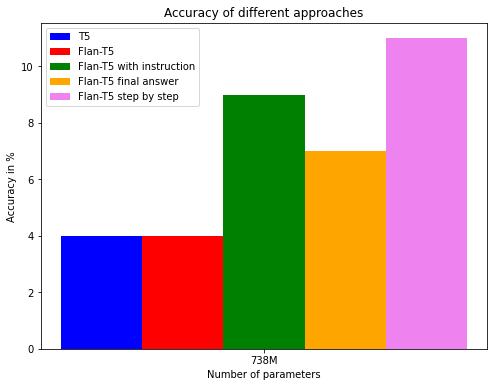

In [39]:
import numpy as np
plt.rcParams["figure.figsize"] = (8,6)
# make bar plot with grouped bars for each of the three settings

# Sample data
x = np.array([1])
sizes = ['738M']

# Create a figure and a set of subplots
fig, ax = plt.subplots()


# Plot data
ax.bar(x - 0.5, [100*accuracies_t5[-1]], width=0.25, color='blue', label="T5")
ax.bar(x - 0.25, [100*accuracies_flan[-1]], width=0.25, color='red', label="Flan-T5")
ax.bar(x, [100*accuracies_flan_instruction[-1]], width=0.25, color='green', label="Flan-T5 with instruction")
ax.bar(x + 0.25, [100*acc_only_final], width=0.25, color='orange', label="Flan-T5 final answer")                   
ax.bar(x + 0.5, [100*acc_step_by_step], width=0.25, color='violet', label="Flan-T5 step by step") 

# Set xticks
ax.set_xticks(x)

# label xticks
ax.set_xticklabels(sizes)

# Set the y axis label
ax.set_ylabel('Accuracy in %')

# Set the chart's title
ax.set_title('Accuracy of different approaches')

# Set the x axis label
ax.set_xlabel('Number of parameters')

# Add a legend
ax.legend()

plt.savefig("plots/Ques4.png")

plt.show()

**BONUS Ques**: Can you come up with another style of step by step reasoning prompts that can prove useful (HINT: check the Socratic version of the dataset.). Test your hypothesis with the same FlanT5 model as above and see the difference.  

**BONUS**:

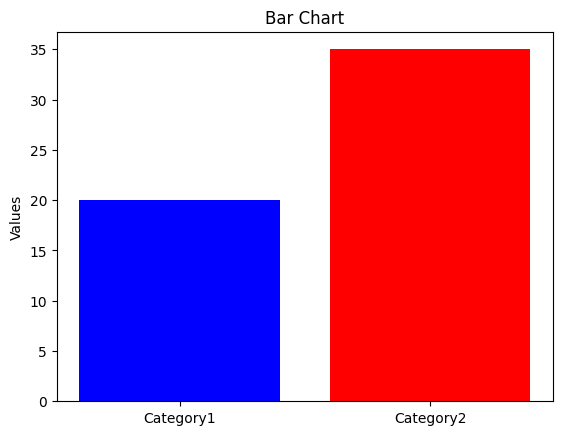

In [ ]:
# Template to plot graphs. 
import matplotlib.pyplot as plt

# Sample data
categories = ['Category1', 'Category2']
values = [20, 35]

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Plot data
ax.bar(categories, values, color=['blue', 'red'])

# Set the y axis label
ax.set_ylabel('Values')

# Set the chart's title
ax.set_title('Bar Chart')

plt.show()